In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

In [2]:
dynamic = pd.read_csv('../input/intubation-prediction/sph_dynamic.csv')
static = pd.read_csv('../input/intubation-prediction/sph_static.csv')

In [3]:
merge_df = pd.merge(dynamic, static, on = 'stay_id')

In [4]:
merge_df['icu_intime'] = pd.to_datetime(merge_df['icu_intime'], format = "%Y-%m-%d %H:%M:%S.%f")

for i in range(len(merge_df)):
        merge_df.loc[i, 'vent_start'] = pd.Timestamp(merge_df.loc[i, 'vent_start']).replace(year = merge_df.loc[i, 'icu_intime'].year)
        merge_df.loc[i, 'vent_end'] = pd.Timestamp(merge_df.loc[i, 'vent_end']).replace(year = merge_df.loc[i, 'icu_intime'].year)

merge_df['vent_start'] = pd.to_datetime(merge_df['vent_start'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['vent_end'] = pd.to_datetime(merge_df['vent_end'], format = "%Y-%m-%d %H:%M:%S.%f")
merge_df['charttime'] = pd.to_datetime(merge_df['charttime'], format = "%Y-%m-%d %H:%M:%S.%f")

In [5]:
#Remove the chart data that is done after 12h in ICU
merge_df = merge_df[(merge_df['charttime'] - merge_df['icu_intime']).dt.total_seconds() <= 43200]  

#Remove the records of the patient that is intubated after 48h in ICU
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() <= 172800]

#Specific case: Last year of the day
merge_df = merge_df[(merge_df['vent_start'] - merge_df['icu_intime']).dt.total_seconds() >= 0]

In [6]:
mean = np.mean(merge_df['vent_duration'])
std_dev = np.std(merge_df['vent_duration'])

merge_df['z_score'] = (merge_df['vent_duration'] - mean) / std_dev

merge_df = merge_df.loc[abs(merge_df['z_score']) <= 3]

In [7]:
merge_df['vent_icuin'] = (merge_df['vent_start'] - merge_df['icu_intime']).apply(lambda x: x.total_seconds())

In [8]:
merge_df = merge_df.sort_values(['stay_id', 'charttime'])

In [9]:
merge_df = merge_df.loc[(merge_df['icu_intime'] - merge_df['charttime']).apply(lambda x: x.total_seconds()) <= 31 * 60 * 60 * 60]

In [10]:
merge_df

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,icu_intime,vent_start,vent_end,vent_duration,z_score,vent_icuin
6204,30004144,2126-04-04 09:30:00,NaN,8.0,0.7,114.0,135.0,103.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,25.000000,-0.269266,95975.0
6203,30004144,2126-04-04 13:06:00,NaN,6.8,0.7,133.0,135.0,102.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,25.000000,-0.269266,95975.0
6991,30005366,2202-12-28 02:10:00,NaN,8.8,6.7,41.0,139.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2202-12-27 17:36:59,2202-12-28 14:00:00,2202-12-28 20:00:00,6.000000,-0.598952,73381.0
2701,30006983,2159-10-11 13:20:00,NaN,8.0,0.8,156.0,132.0,102.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,49.000000,0.147178,50598.0
2700,30006983,2159-10-12 04:28:00,NaN,7.1,1.0,89.0,136.0,108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,49.000000,0.147178,50598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,39985110,2141-03-02 18:40:00,NaN,10.2,5.2,125.0,138.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0
3898,39985110,2141-03-02 21:35:00,NaN,10.1,5.6,126.0,138.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0
3896,39985110,2141-03-03 12:37:00,NaN,10.4,6.8,149.0,139.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0
4182,39992167,2114-06-10 21:12:00,NaN,7.9,0.9,113.0,131.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2114-06-10 19:00:00,2114-06-11 17:00:00,2114-06-15 05:00:00,84.000000,0.754494,79200.0


In [11]:
# dynamic['charttime'] = pd.to_datetime(dynamic['charttime'], format = "%Y-%m-%d %H:%M:%S.%f")

In [12]:
# dynamic = dynamic.sort_values(['stay_id', 'charttime'], ascending = True)
# dynamic

In [13]:
# pd.Timedelta((dynamic['charttime'].values[1] - dynamic['charttime'].values[0]).astype('timedelta64[m]')).seconds // 60

In [14]:
# stiatic = static.sort_values(['stay_id'], ascending = True)
# static

Count the number of unique `stay_id` in each dataframe.

In [15]:
print('Unique ID numbers: ', len(merge_df['stay_id'].unique()))

Unique ID numbers:  1684


In [16]:
# dynamic[dynamic['stay_id'] == 30004144].iloc[0,:]

Extract the first record of each unique `stay_id` in the dynamic dataset

In [17]:
first_record = []

for i in merge_df['stay_id'].unique():
    first_record.append(merge_df[merge_df['stay_id'] == i].iloc[0])

In [18]:
first_record = pd.DataFrame(first_record)

In [19]:
first_record

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,icu_intime,vent_start,vent_end,vent_duration,z_score,vent_icuin
6204,30004144,2126-04-04 09:30:00,NaN,8.0,0.7,114.0,135.0,103.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,25.000000,-0.269266,95975.0
6991,30005366,2202-12-28 02:10:00,NaN,8.8,6.7,41.0,139.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2202-12-27 17:36:59,2202-12-28 14:00:00,2202-12-28 20:00:00,6.000000,-0.598952,73381.0
2701,30006983,2159-10-11 13:20:00,NaN,8.0,0.8,156.0,132.0,102.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,49.000000,0.147178,50598.0
6456,30023204,2124-07-09 17:15:00,NaN,8.2,1.6,124.0,130.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2124-07-09 16:43:55,2124-07-11 16:00:00,2124-07-12 16:10:00,24.166667,-0.283726,170165.0
4098,30034749,2191-04-30 22:10:00,NaN,9.9,0.8,166.0,140.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2191-05-06 09:56:40,2191-05-07 12:28:00,2191-05-08 08:55:00,20.450000,-0.348217,95480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120,39972274,2185-03-08 17:10:00,NaN,9.3,0.9,89.0,140.0,106.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2185-03-09 01:32:00,2185-03-09 16:51:00,2185-03-10 11:00:00,18.150000,-0.388127,55140.0
1192,39977971,2115-12-11 07:00:00,NaN,9.0,1.9,96.0,134.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2115-12-11 17:42:45,2115-12-12 12:00:00,2115-12-12 16:00:00,4.000000,-0.633656,65835.0
6531,39982332,2180-03-01 23:46:00,NaN,NaN,1.2,119.0,140.0,103.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2180-03-01 22:35:04,2180-03-02 19:00:00,2180-03-03 08:00:00,13.000000,-0.477489,73496.0
3897,39985110,2141-03-02 18:40:00,NaN,10.2,5.2,125.0,138.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0


In [20]:
minutes_l = []
for i in range(merge_df.shape[0]):
    stay_id = merge_df.iloc[i,:]['stay_id']
    minutes_l.append((merge_df.iloc[i,:]['charttime'] - first_record[first_record['stay_id'] == stay_id]['charttime'].values[0]).seconds // 60)

In [21]:
# merge_df.iloc[0,:]['charttime']

In [22]:
# first_record[first_record['stay_id'] == 30004144]['charttime']

In [23]:
merge_df['minutes'] = minutes_l
merge_df

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,sofa_cardiovascular,sofa_cns,sofa_renal,icu_intime,vent_start,vent_end,vent_duration,z_score,vent_icuin,minutes
6204,30004144,2126-04-04 09:30:00,NaN,8.0,0.7,114.0,135.0,103.0,NaN,NaN,...,NaN,NaN,NaN,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,25.000000,-0.269266,95975.0,0
6203,30004144,2126-04-04 13:06:00,NaN,6.8,0.7,133.0,135.0,102.0,NaN,NaN,...,NaN,NaN,NaN,2126-04-04 13:20:25,2126-04-05 16:00:00,2126-04-06 17:00:00,25.000000,-0.269266,95975.0,216
6991,30005366,2202-12-28 02:10:00,NaN,8.8,6.7,41.0,139.0,100.0,NaN,NaN,...,NaN,NaN,NaN,2202-12-27 17:36:59,2202-12-28 14:00:00,2202-12-28 20:00:00,6.000000,-0.598952,73381.0,0
2701,30006983,2159-10-11 13:20:00,NaN,8.0,0.8,156.0,132.0,102.0,NaN,NaN,...,NaN,NaN,NaN,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,49.000000,0.147178,50598.0,0
2700,30006983,2159-10-12 04:28:00,NaN,7.1,1.0,89.0,136.0,108.0,NaN,NaN,...,NaN,NaN,NaN,2159-10-12 03:56:42,2159-10-12 18:00:00,2159-10-14 19:00:00,49.000000,0.147178,50598.0,908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,39985110,2141-03-02 18:40:00,NaN,10.2,5.2,125.0,138.0,98.0,NaN,NaN,...,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0,0
3898,39985110,2141-03-02 21:35:00,NaN,10.1,5.6,126.0,138.0,98.0,NaN,NaN,...,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0,175
3896,39985110,2141-03-03 12:37:00,NaN,10.4,6.8,149.0,139.0,98.0,NaN,NaN,...,NaN,NaN,NaN,2141-03-03 05:57:46,2141-03-04 20:44:00,2141-03-06 04:00:00,31.266667,-0.160528,139574.0,1077
4182,39992167,2114-06-10 21:12:00,NaN,7.9,0.9,113.0,131.0,100.0,NaN,NaN,...,NaN,NaN,NaN,2114-06-10 19:00:00,2114-06-11 17:00:00,2114-06-15 05:00:00,84.000000,0.754494,79200.0,0


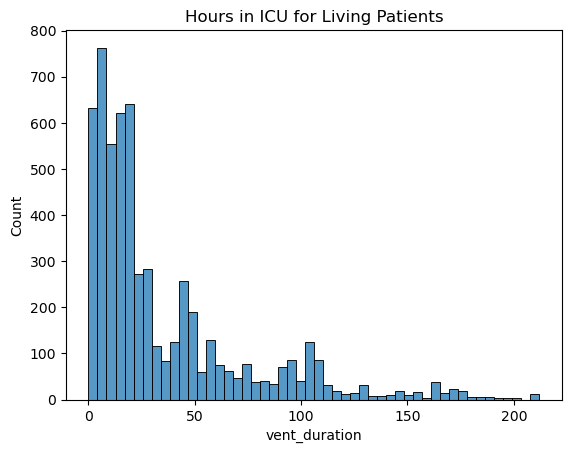

In [24]:
sns.histplot(data = merge_df, x = merge_df['vent_duration'])
plt.title('Hours in ICU for Living Patients')
plt.show()

Create a dictionary to store the number of records in the `dynamic` dataframe for each `stay_id`

In [25]:
dict_ = {i:0 for i in set(merge_df['stay_id'].unique())}

for i in merge_df['stay_id']:
    dict_[i] += 1

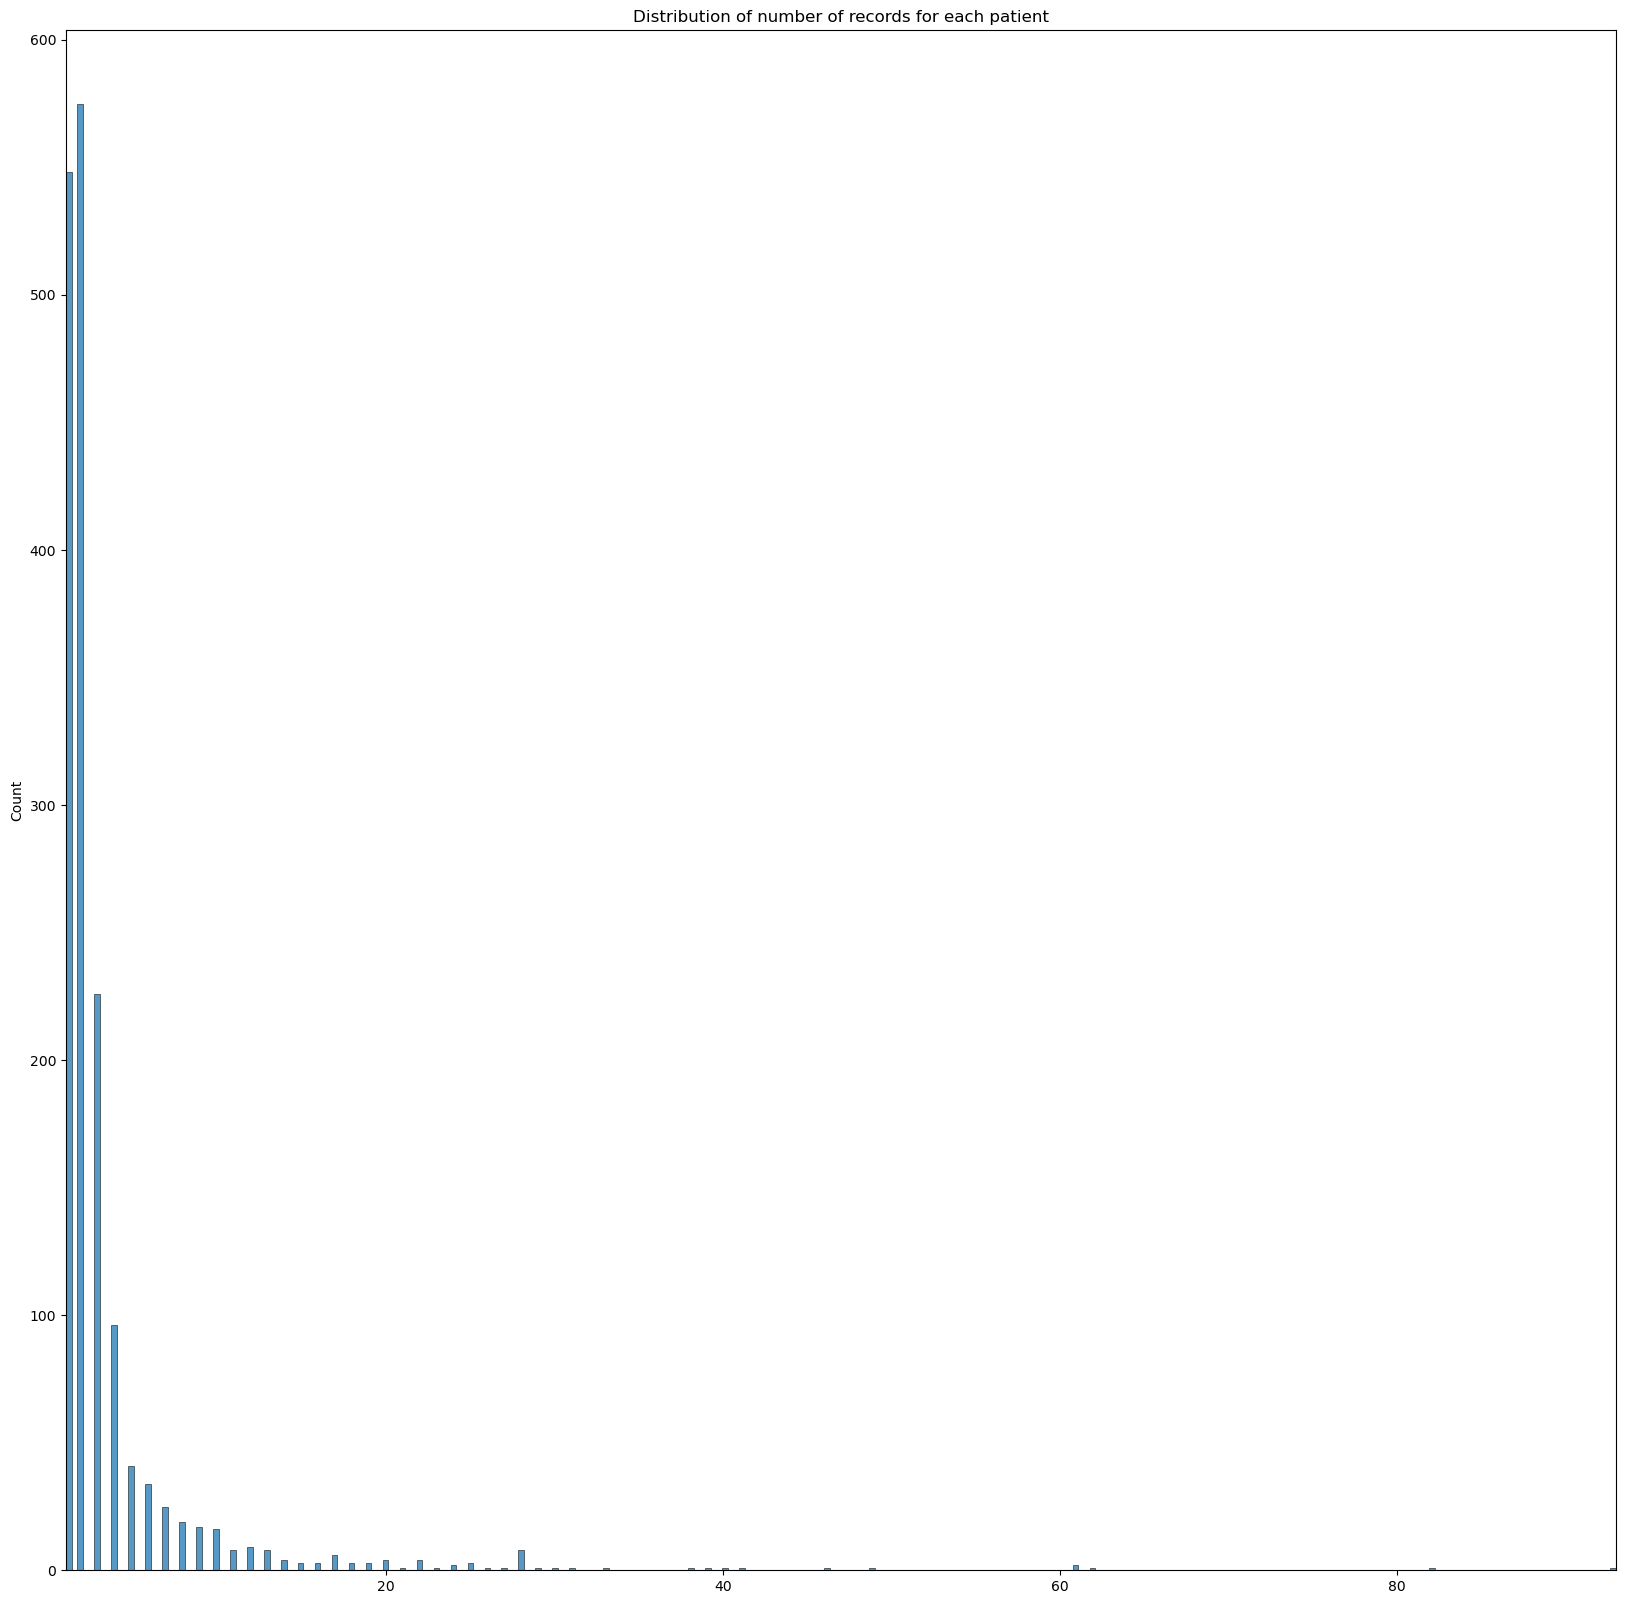

In [26]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.histplot(data = dict_, x = dict_.values(), ax = ax)
plt.title('Distribution of number of records for each patient')
plt.xlim((min(dict_.values()), max(dict_.values())))
plt.show()

In [27]:
print('The missing rate of each column:')
merge_df.isna().mean().sort_values()

The missing rate of each column:


stay_id                0.000000
z_score                0.000000
vent_duration          0.000000
vent_end               0.000000
vent_start             0.000000
icu_intime             0.000000
vent_icuin             0.000000
minutes                0.000000
charttime              0.000000
sodium                 0.028017
chloride               0.031282
creatinine             0.036095
glucose                0.056377
calcium                0.129942
hemoglobin             0.163630
wbc                    0.167068
pt                     0.436061
ast                    0.579065
bilirubin_total        0.581643
alt                    0.582846
alp                    0.585253
bilirubin_direct       0.970780
bilirubin_indirect     0.971124
resp_rate              0.971468
heart_rate             0.971640
sofa_cardiovascular    0.977484
mbp                    0.979202
dbp                    0.980406
sbp                    0.980406
total_protein          0.987109
urineoutput            0.987796
temperat

In [28]:
missing_percent = merge_df.isna().sum() / len(merge_df)

df = merge_df.drop(columns = missing_percent[missing_percent > 0.4].index)

In [29]:
# df = df.fillna(df.mean())

In [30]:
# df = df.fillna(df.median())

In [31]:
durations = []
for i in df['stay_id'].unique():
    durations.append(df[df['stay_id'] == i]['vent_duration'].values[0])

In [32]:
def normalize_data(df, column):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df[column] = min_max_scaler.fit_transform(df[column].values.reshape(-1,1))
    return df

numeric_features = ['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'vent_icuin']

for c in numeric_features:
    normalize_data(df, c)

In [33]:
imputer = KNNImputer(n_neighbors = 5)

df[numeric_features] = imputer.fit_transform(df[numeric_features])

In [34]:
len(df['stay_id'].unique())

1684

In [35]:
time_df = [[0 for _ in range(max(minutes_l) + 1)] for i in range(len(df['stay_id'].unique()))] 
row = 0
for unique_id in df['stay_id'].unique():
    for i in range(df[df['stay_id'] == unique_id].shape[0]):
        time_df[row][minutes_l[i]] = list(df[df['stay_id'] == unique_id][numeric_features].values[i])
    row += 1

In [36]:
df_time = pd.DataFrame(time_df)

In [37]:
df_time

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,"[0.46913580246913567, 0.030612244897959186, 0....",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[0.5679012345679012, 0.33673469387755106, 0.00...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[0.46913580246913567, 0.035714285714285726, 0....",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[0.530864197530864, 0.0663265306122449, 0.0261...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[0.6666666666666664, 0.035714285714285726, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,"[0.6296296296296297, 0.040816326530612256, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1680,"[0.5802469135802467, 0.10714285714285716, 0.02...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,"[0.5530864197530863, 0.056122448979591844, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1682,"[0.7654320987654321, 0.3418367346938776, 0.040...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_time['vent_duration'] = durations
df_time

,0,1,2,3,4,5,6,7,8,9,...,1431,1432,1433,1434,1435,1436,1437,1438,1439,vent_duration
0,"[0.46913580246913567, 0.030612244897959186, 0....",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25.000000
1,"[0.5679012345679012, 0.33673469387755106, 0.00...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.000000
2,"[0.46913580246913567, 0.035714285714285726, 0....",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49.000000
3,"[0.530864197530864, 0.0663265306122449, 0.0261...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24.166667
4,"[0.6666666666666664, 0.035714285714285726, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,"[0.6296296296296297, 0.040816326530612256, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18.150000
1680,"[0.5802469135802467, 0.10714285714285716, 0.02...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.000000
1681,"[0.5530864197530863, 0.056122448979591844, 0.0...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.000000
1682,"[0.7654320987654321, 0.3418367346938776, 0.040...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.266667


In [39]:
# df_time = df_time.loc[df_time['vent_duration'] <= 104]

In [40]:
# df_time.to_csv('df_time.csv')

In [41]:
# df_time = df_time.fillna(0)

In [42]:
# df_time = df_time.drop(df_time[df_time['vent_duration'] > 200].index)

In [43]:
# x_train = df_time.iloc[:1244,:]
# y_train = static['vent_duration'].values[:1244]

# x_test = df_time.iloc[534:,:]
# y_test = static['vent_duration'].values[534:]
x_train, x_test, y_train, y_test = train_test_split(df_time.iloc[:, :-1], df_time['vent_duration'], random_state = 42)

<AxesSubplot:xlabel='vent_duration', ylabel='Count'>

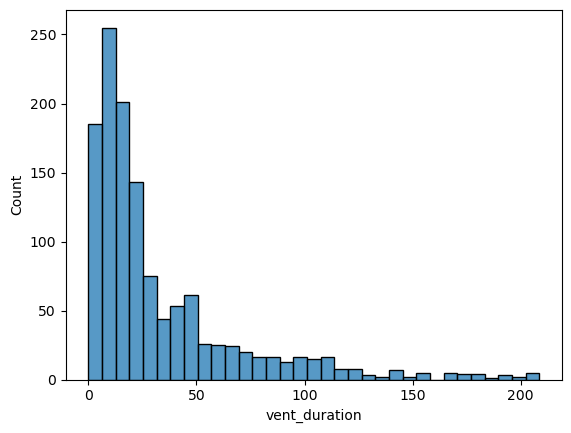

In [44]:
sns.histplot(y_train)

In [45]:
# int_l = [int(i) for i in y_train]
# dict_ = {x:0 for x in set(int_l)}
# for i in int_l:
#     dict_[i] += 1
# tmp = []
# for k, v in dict_.items():
#     tmp.append((k, v))

# sorted([x for x in zip(dict_.keys(), dict_.values())], key = lambda zipped: zipped[1], reverse = True)

In [46]:
# from scipy import stats

# fitted_ytrain, fitted_lambda = stats.boxcox(y_train)
# sns.histplot(fitted_ytrain)

In [47]:
x_train = x_train.values.tolist()
x_train = [[x if isinstance(x, list) else [x] * 8 for x in row] for row in x_train]
x_train = np.array(x_train)

In [48]:
x_test = x_test.values.tolist()
x_test = [[x if isinstance(x, list) else [x] * 8 for x in row] for row in x_test]
x_test = np.array(x_test)

# SimpleRNN

In [49]:
# model = keras.Sequential()
# model.add(layers.Masking(mask_value = [0, 0, 0, 0, 0, 0, 0]))
# model.add(layers.SimpleRNN(32))
# model.add(layers.Dense(1))

# model.compile(loss = 'mse', optimizer = 'rmsprop')

In [50]:
# history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2)

# plt.plot(history.history['loss'], label = 'Training Loss')
# plt.plot(history.history['val_loss'], label = 'Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [51]:
max(y_train), min(y_train)

(208.6666667, 0.016666667)

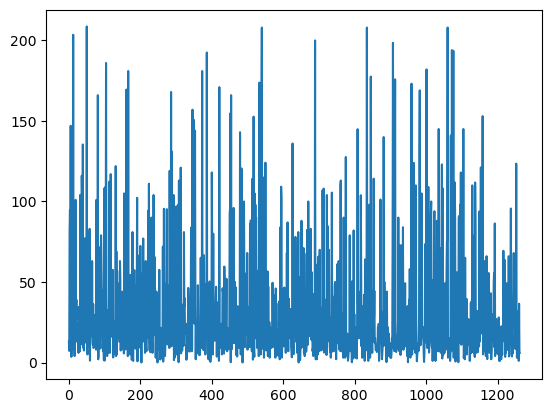

In [52]:
plt.plot(y_train.values)

# LSTM

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers,regularizers
from keras.layers import LeakyReLU
import keras.backend as K
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor


def weighted_mse(y_true, y_pred):
    # Calculate the median value of y_true

    # Calculate the weights based on the distance from the median
    #weights = K.cast(K.less(y_true, 25), K.floatx()) * 10 + K.cast(K.greater_equal(y_true, 125), K.floatx()) * 25 
    weights = K.cast(K.less(y_true, 25), K.floatx()) * 10 + K.cast(K.greater_equal(y_true, 200), K.floatx()) * 35
    # Normalize the weights to have a maximum value of 1

    # Calculate the weighted mean squared error loss
    mse = K.mean(K.square(y_pred - y_true) * weights)

    return mse

# def multi_loss(y_true, y_pred):
#     # Calculate the median value of y_true

#     # Calculate the weights based on the distance from the median
#     #weights = K.cast(K.less(y_true, 25), K.floatx()) * 10 + K.cast(K.greater_equal(y_true, 125), K.floatx()) * 25 
#     weights = K.cast(K.greater_equal(y_true, 200), K.floatx()) * 10
#     # Calculate the weighted mean squared error loss
#     weight_mse = K.mean(K.square(y_pred - y_true) * weights)
#     # Normalize the weights to have a maximum value of 1
#     mse = K.mean(K.square(y_pred - y_true))


#     return 0.9 * mse + 0.1 * weight_mse

# def create_model(optimizer='adam', activation='relu'):
#     model = keras.Sequential([
#         layers.Masking(mask_value = 0),
#         layers.LSTM(64, return_sequences = False ,activation = 'softsign'), 
#         layers.BatchNormalization(),
#         layers.Dense(10,activation = 'relu'),
#         layers.Dense(1)  
#     ])
#     model.compile(loss = weighted_mse, optimizer = 'adam', metrics = ['mse', 'mae'])
#     return model

# model = KerasRegressor(build_fn=create_model, verbose=0)

model = keras.Sequential([
    layers.Masking(mask_value = 0),
    layers.LSTM(64, return_sequences = False ,activation = 'softsign'), 
    layers.BatchNormalization(),
    layers.Dense(10,activation = 'relu'),
    layers.Dense(1)
])

# model = keras.Sequential([
#     layers.Masking(mask_value = 0),
#     layers.LSTM(128, return_sequences = True ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.LSTM(64, return_sequences = True ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.LSTM(32, return_sequences = True ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.LSTM(16, return_sequences = False ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.Dense(10,activation = 'relu'),
#     layers.Dense(1)
    
# ])

model.compile(loss = weighted_mse, optimizer = 'adam', metrics = ['mse', 'mae'])

In [54]:
# def huber_loss(y_true, y_pred, clip_delta = 50):
#     error = y_true - y_pred
#     cond  = tf.keras.backend.abs(error) > clip_delta

#     squared_loss = 0.5 * tf.keras.backend.square(error)
#     linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

#     return tf.where(cond, squared_loss, linear_loss)

# model = keras.Sequential([
#     layers.Masking(mask_value = 0),
#     layers.GRU(64, return_sequences = False ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.Dense(10,activation = 'relu'),
#     layers.Dense(1)
    
# ])

# model.compile(loss = huber_loss, optimizer = 'adam', metrics = ['mse', 'mae'])

In [55]:
# model = keras.Sequential([
#     layers.Masking(mask_value = 0),
#     layers.LSTM(64, return_sequences = False ,activation = 'softsign'), 
#     layers.BatchNormalization(),
#     layers.Dense(10,activation = 'relu'),
#     layers.Dense(1)
    
# ])

# model.compile(loss = 'mse', optimizer = 'adam')

In [56]:
# param_grid = {
#     'batch_size': [16, 32, 64],
#     'epochs': [10, 20, 30],
#     'optimizer': ['adam', 'rmsprop'],
# }

# grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = mean_squared_error)
# result = grid_search.fit(x_train, y_train)

Epoch 1/25
64/64 [==============================] - 50s 739ms/step - loss: 8022.2607 - mse: 2350.9695 - mae: 30.6815 - val_loss: 6767.0396 - val_mse: 2465.1106 - val_mae: 32.8502
Epoch 2/25
64/64 [==============================] - 47s 732ms/step - loss: 7631.0503 - mse: 2188.6104 - mae: 28.3246 - val_loss: 6591.3057 - val_mse: 2395.4922 - val_mae: 31.8439
Epoch 3/25
64/64 [==============================] - 45s 709ms/step - loss: 7360.4546 - mse: 2049.6040 - mae: 26.7507 - val_loss: 6328.5205 - val_mse: 2285.7314 - val_mae: 30.3004
Epoch 4/25
64/64 [==============================] - 46s 721ms/step - loss: 7149.0522 - mse: 1951.9049 - mae: 25.7064 - val_loss: 5985.4092 - val_mse: 2124.6206 - val_mae: 28.2626
Epoch 5/25
64/64 [==============================] - 46s 725ms/step - loss: 7050.0859 - mse: 1905.0771 - mae: 25.2727 - val_loss: 5857.6963 - val_mse: 2050.6016 - val_mae: 27.5097
Epoch 6/25
64/64 [==============================] - 47s 742ms/step - loss: 6904.0215 - mse: 1883.5315 - m

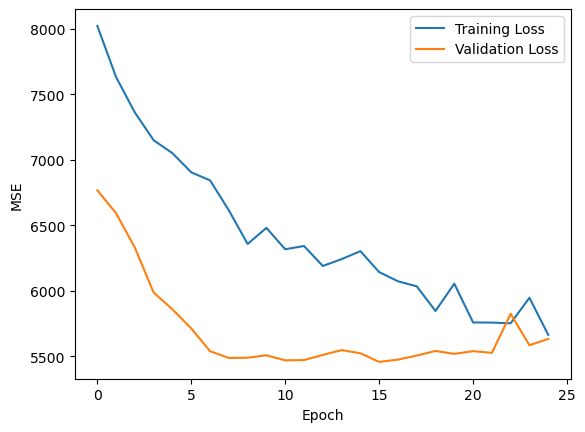

In [57]:
history = model.fit(x_train, y_train, epochs = 25, batch_size = 16, validation_split = 0.2)

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# history = model.fit(x_train, fitted_ytrain, epochs = 20, batch_size = 32, validation_split = 0.2)

# plt.plot(history.history['loss'], label = 'Training Loss')
# plt.plot(history.history['val_loss'], label = 'Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [58]:
y_pred = model.predict(x_test)

14/14 [==============================] - 3s 218ms/step


In [59]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor

ModuleNotFoundError: No module named 'mapie'

In [ ]:
median_pipeline = Pipeline([('median_model', model)])
median_pipeline.fit(x_train, y_train)
pred_median = median_pipeline.predict(x_test)


# Evaluate model performance at record level

print('RMSE = ' + str(mean_squared_error(y_test, pred_median, squared=False)))

# Fit estimated prediction intervals

mapie = MapieRegressor(
    median_pipeline, method="naive", cv=TimeSeriesSplit(), agg_function=None, n_jobs=-1
)

mapie.fit(x_train, y_train)
pred_median, y_pis = mapie.predict(x_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test.values, lw=2, label="Actual", c="C0")
ax.plot(pred_median, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    [i for i in range(len(y_test))],
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("Our model: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.show

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(y_test.values)
plt.plot(lst)
plt.show

In [ ]:
rmse = mean_squared_error(y_test.values, y_pred) ** 0.5
print(rmse)

In [ ]:
rmse = mean_squared_error(y_test.values, lst) ** 0.5
print(rmse)

In [ ]:
tmp = pd.DataFrame()
tmp['y_test'] = y_test.values
tmp['y_pred'] = y_pred

tmp = tmp.loc[tmp['y_test'] <= 48]

In [ ]:
plt.plot(tmp['y_test'])
plt.plot(tmp['y_pred'])
plt.show

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(tmp['y_test'], tmp['y_pred'])

print(mse)

In [ ]:
1450 ** (1 / 2)

In [ ]:
def bin_fun(x):
    if 0 <= x <= 24:
        return 1
    elif 24 <= x <= 48:
        return 2
    elif 48 <= x <= 72:
        return 3
    else:
        return 4

# def bin_fun(x):
#     if 0 <= x <= 24:
#         return 1
#     else:
#         return 2

In [ ]:
df_time = pd.DataFrame(time_df)

In [ ]:
df_time['vent_duration'] = durations

In [ ]:
df_time['vent_duration'] = df_time['vent_duration'].apply(bin_fun)

In [ ]:
df_time['vent_duration'].value_counts()

In [ ]:
# X = df_time.iloc[:, :-1]
# y = df_time['vent_duration']

# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state = 42)
# X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state = 42)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_time.iloc[:, :-1], df_time['vent_duration'], random_state = 42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(y_train.values.reshape(-1, 1))

one_hot_y_train = encoder.transform(y_train.values.reshape(-1 ,1)).toarray()
one_hot_y_test = encoder.transform(y_test.values.reshape(-1 ,1)).toarray()

In [ ]:
x_train = x_train.values.tolist()
x_train = [[x if isinstance(x, list) else [x] * 8 for x in row] for row in x_train]
x_train = np.array(x_train)

In [ ]:
x_test = x_test.values.tolist()
x_test = [[x if isinstance(x, list) else [x] * 8 for x in row] for row in x_test]
x_test = np.array(x_test)

In [ ]:
model = keras.Sequential([
    layers.Masking(mask_value = 0),
    layers.LSTM(64, return_sequences = False ,activation = 'softsign'), 
    layers.BatchNormalization(),
    layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, one_hot_y_train, epochs = 10, batch_size = 64, validation_split = 0.1)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
#fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.show